# Waveform inspection

This is a simple function for inspecting the waveform from a scope-like readout.
This is basically a histogram aggregated from the raw data that is stored the
`waveform_container` container. Let us start by importing the required
libraries, and loading in an example file.


In [1]:
import sipmanalyze.formats as forms
import sipmanalyze.plotting as plt
import awkward as ak
import numpy as np
import hist

container = forms.waveform.waveform_container.from_root("data/waveform_example.root")


The histogram can then be constructed using the waveform array and the readout
settings in the container. For this simple example, we will not be modifying the
data other than bit conversion to nominal units.

In [2]:
tstart, tstop = 0, len(container.waveforms[0])  # Default output
vmin, vmax = ak.min(container.waveforms), ak.max(container.waveforms)

# Getting the integer count of bins
tbins = tstop - tstart
vbins = np.abs(vmax - vmin)

# Converting to human readable units
tint = container.settings.timeintervals
tstop, tstart = tstop * tint, tstart * tint

vadc = container.settings.adc_val
vmin, vmax = vmin * vadc, vmax * vadc

# Defining and filling the histogram
h = hist.Hist(hist.axis.Regular(tbins+1, tstart, tstop, name='t'),
              hist.axis.Regular(vbins+1, vmin, vmax, name='v'))

h.fill(t=ak.flatten(ak.local_index(container.waveforms, axis=-1)) * tint,
       v=ak.flatten(container.waveforms) * vadc)


/tmp/ipykernel_281556/3379692262.py:6: RuntimeWarning: overflow encountered in scalar subtract
  vbins = np.abs(vmax - vmin)


Hist(
  Regular(151, 0, 118.11, name='t'),
  Regular(128, -254, 4, name='v'),
  storage=Double()) # Sum: 14999988.0 (15000000.0 with flow)

Next we can formally plot the results

<Axes: xlabel='Time [ns]', ylabel='Readout [mV]'>

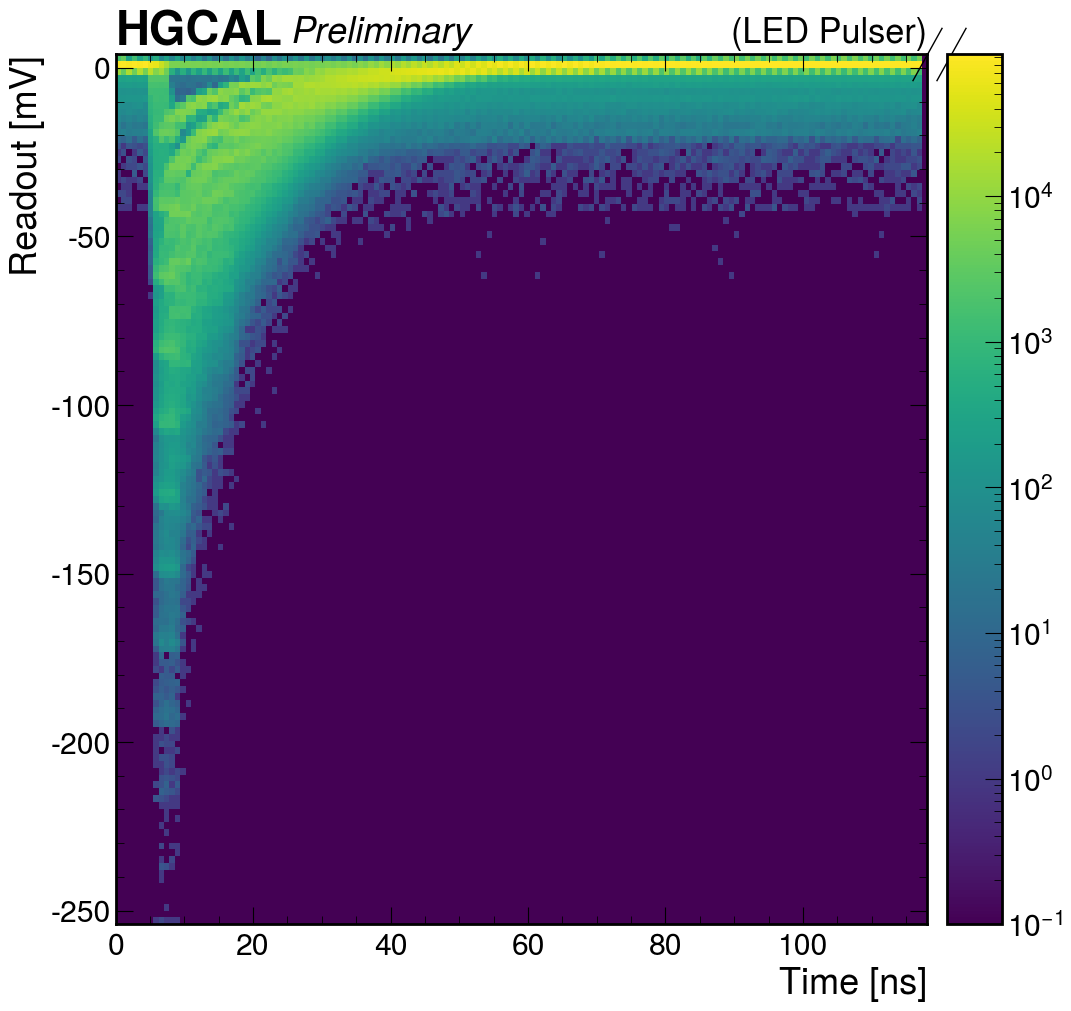

In [3]:
fig, ax = plt.make_simple_figure()

h.view()[:] = ak.where(h.view() == 0, 0.1, h.view()) # Setting 0 bins to 0.3 events
h.plot2d(ax=ax, norm=plt.matplot.colors.LogNorm())

ax.set_xlabel('Time [ns]')
ax.set_ylabel('Readout [mV]')

plt.mplhep.cms.text('Preliminary', exp='HGCAL', ax=ax)
plt.mplhep.cms.lumitext('(LED Pulser)')

We can also perform the standard transformation of taking the waveform integral
for the leading time slices, we also invert the output so that the gain positive.

In [4]:
area = ak.sum(container.waveforms[:, 5:30], axis=-1) * tint * vadc * -1

amin, amax = ak.min(area), ak.max(area)
nbins = int((amax - amin) / tint / vadc / 4)

h2 = hist.Hist(hist.axis.Regular(nbins, amin, amax, name='r'))
h2.fill(area)


Hist(Regular(355, -11.0236, 2226.77, name='r'), storage=Double()) # Sum: 99999.0 (100000.0 with flow)

Then we can formally plot the results

<Axes: xlabel='Readout [mV-ns]', ylabel='Number of events'>

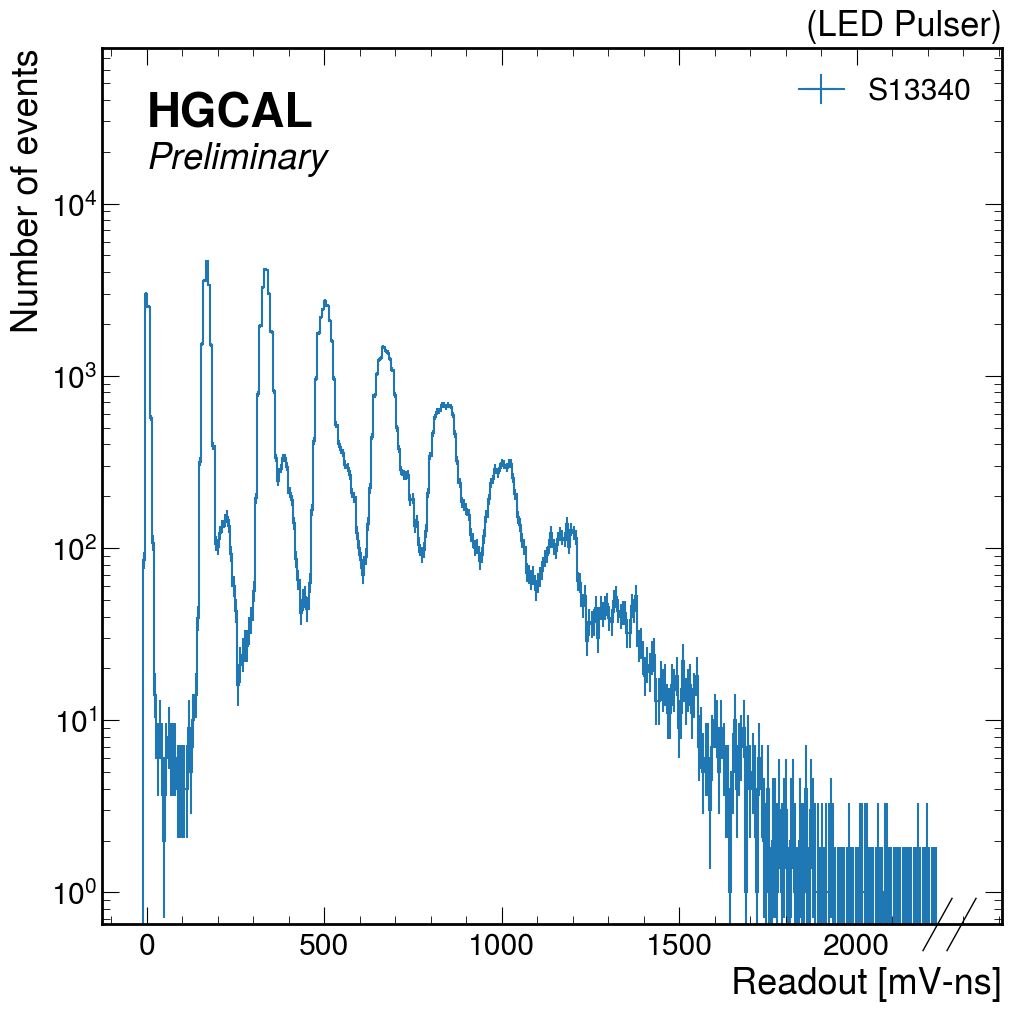

In [5]:
fig, ax = plt.make_simple_figure()

h2.plot(ax=ax, label='S13340')

ax.set_xlabel('Readout [mV-ns]')
ax.set_ylabel('Number of events')
ax.set_yscale('log')
ax.legend()

plt.add_std_label(ax=ax, label='Preliminary', rlabel='(LED Pulser)')
